# **IAA - PRÀCTICA: MAIN**

**Instal·lar llibreries necessàries**

In [ ]:
%pip install -r ../assets/requirements.txt 

**Importar llibreries**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from ucimlrepo import fetch_ucirepo 

**Llegir les dades (Cirrhosis Dataset)**

In [23]:
# Fetch dataset
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878)

data = pd.DataFrame(cirrhosis_patient_survival_prediction.data.original)

# Guardem el dataset per poder-lo visualitzar sencer
data.to_csv('../assets/data/raw_cirrhosis.csv')

**Informació del dataset inicial**

In [ ]:
data.shape

In [ ]:
data.head(-10)

In [ ]:
data.info()

**Preprocessing inicial**

In [24]:
# Reemplaçar l'string 'NaNN' per NaN
data.replace(to_replace=['NaNN', '', pd.NA], value=np.nan, inplace=True)

In [ ]:
data.head(-10)

In [25]:
# Assignem els tipus de dades correctes a cada columna
int64_variables = ['N_Days', 'Age', 'Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']
float64_variables = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT', 'Prothrombin']
category_variables = ['ID', 'Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

data[int64_variables] = data[int64_variables].astype('Int64')
data[float64_variables] = data[float64_variables].astype('float64')
data[category_variables] = data[category_variables].astype('category')

In [27]:
# Renombrem les classes d'algunes variables per una millor comprensió
data['Status'] = data['Status'].replace({'D': 'Dead', 'C': 'Alive', 'CL': 'Liver Transplant'})


In [28]:
data.to_csv('../assets/data/preprocessed_cirrhosis.csv')

**Anàlisis de les variables**

In [ ]:
data.head(-10)

In [29]:
data.isna().sum().sort_values(ascending=False)

Tryglicerides    136
Cholesterol      134
Copper           108
Drug             106
Ascites          106
Hepatomegaly     106
Spiders          106
SGOT             106
Alk_Phos         106
Platelets         11
Stage              6
Prothrombin        2
ID                 0
Albumin            0
N_Days             0
Edema              0
Sex                0
Age                0
Status             0
Bilirubin          0
dtype: int64

In [ ]:
# Estudi de les variables numèriques
data.describe()

In [ ]:
# Estadístiques de les variables categòriques
data.describe(include='category')

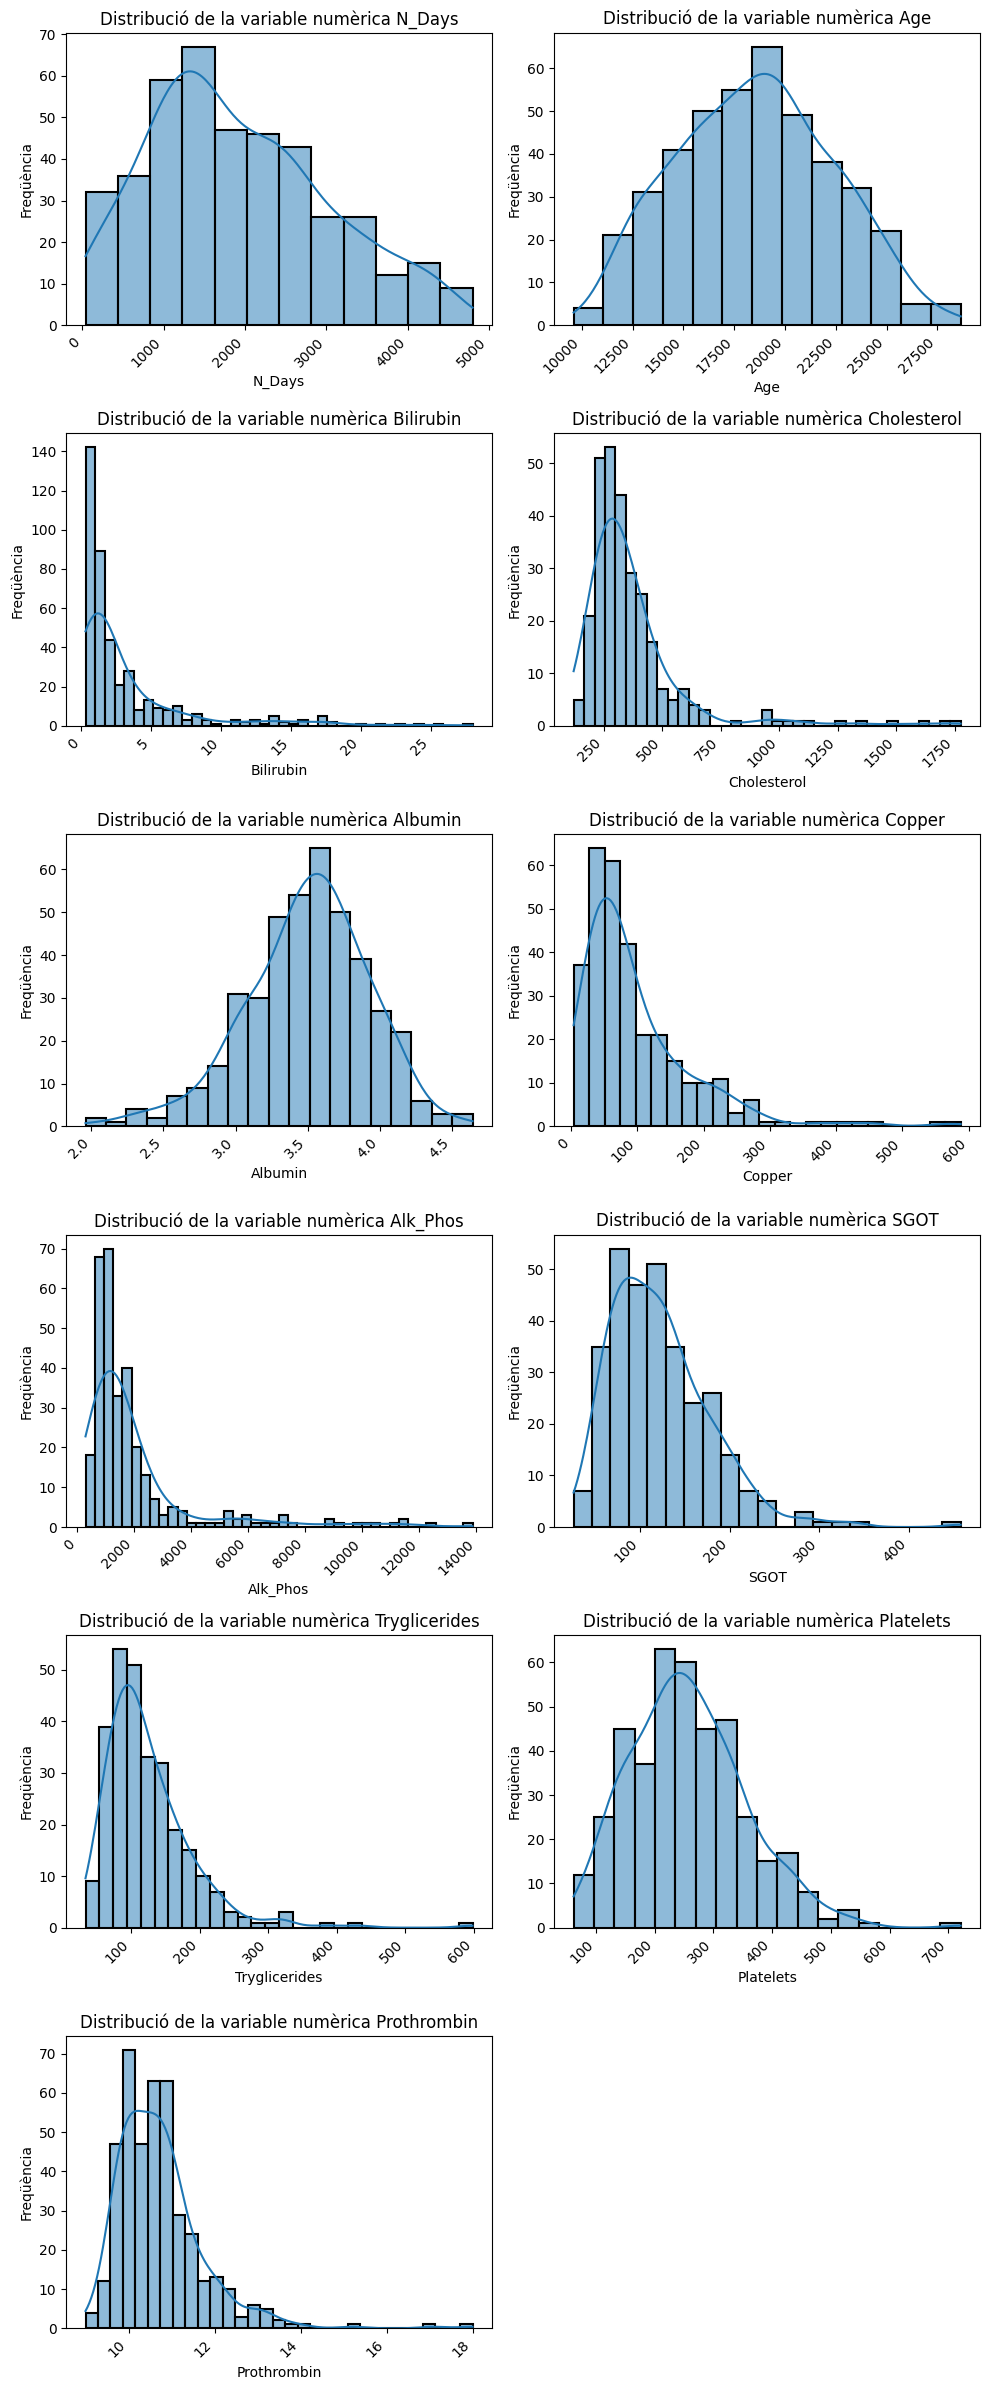

In [30]:
# Visualització de les distribucions de les variables numèriques en una sola figura
numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

num_rows = int(np.ceil(len(numerical_columns) / 2))

fig = plt.figure(figsize=(10, num_rows * 4))

for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(num_rows, 2, i + 1)
    
    sns.histplot(data[col], edgecolor="k", linewidth=1.5, kde=True)
    
    plt.xticks(rotation=45, ha='right')
    
    ax.set_title(f'Distribució de la variable numèrica {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Freqüència')

plt.tight_layout()
plt.show()

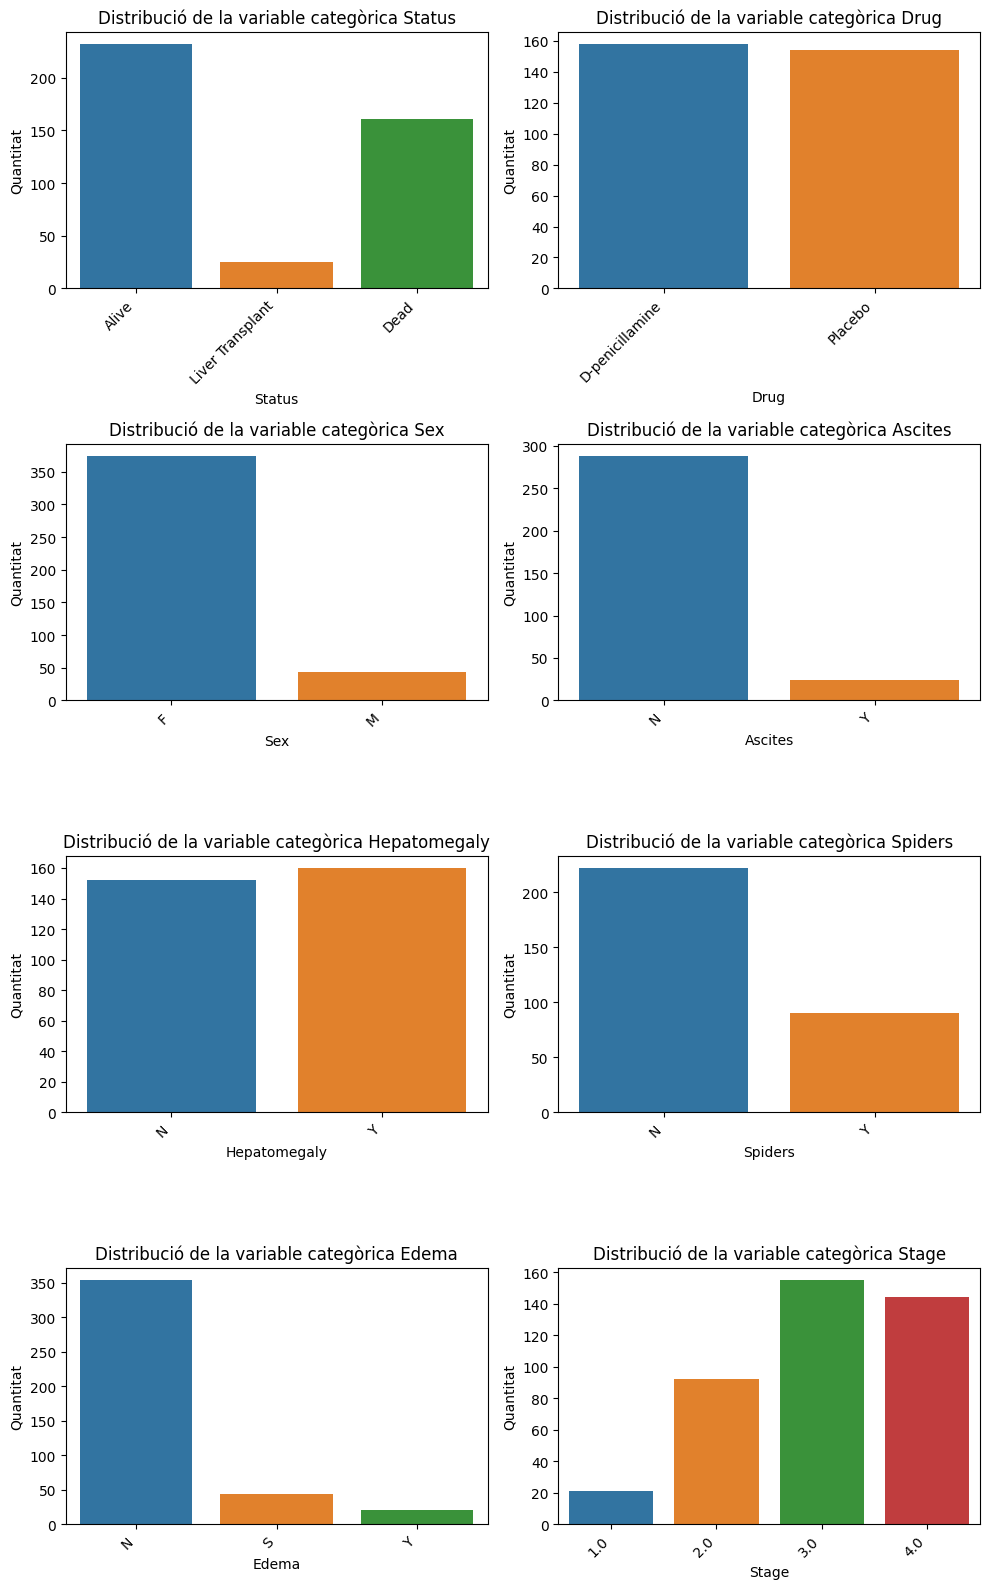

In [32]:
# Visualització de les distribucions de les variables categòriques en una sola figura (menys ID)
categorical_columns = data.select_dtypes(include=['category']).columns.drop(['ID'])
num_rows = int(np.ceil(len(categorical_columns) / 2))

fig = plt.figure(figsize=(10, num_rows * 4))

for i, col in enumerate(categorical_columns):
    ax = fig.add_subplot(num_rows, 2, i + 1)
    
    sns.countplot(data=data, x=col, ax=ax, hue=col, legend=False)
    
    plt.xticks(rotation=45, ha='right')
    
    ax.set_title(f'Distribució de la variable categòrica {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Quantitat')

plt.tight_layout()
plt.show()

**Partició del dataset**

**Imputar els valors faltants (Missings)**

**1r Model: K-Nearest Neighbors (KNN)**

**2n Model: Decision Tree**

**3r Model: Support Vector Machine (SVM)**